In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from itertools import cycle
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score

**Load Data**


Mengambil data dan kemudian membersihkan nama kolom dengan menghapus karakter newlie ("\n")

In [ ]:
url = 'https://drive.google.com/file/d/1E116RNpCU4OhRa7F3Kr1B6yiyb-WFC62/view?usp=sharing'
url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]

df = pd.read_csv(url)
# Remove newline characters from column names
df.columns = [col.replace('\n', '') for col in df.columns]
df

,Provinsi,Kota/Kabupaten,UHH (Tahun),HLS (Tahun),RLS (Tahun),Pengeluaran (Ribu Rupiah),IPM
0,Papua,Papua-Merauke,67.31,14.20,9.04,10.424,71.24
1,Papua,Jayawijaya,60.26,12.83,5.74,7.765,59.60
2,Papua,Jayapura,67.45,14.40,10.27,10.230,72.67
3,Papua,Nabire,68.41,12.44,10.16,9.040,69.91
4,Papua,Kepulauan Yapen,69.39,12.80,9.69,7.685,68.41
...,...,...,...,...,...,...,...
236,Maluku,Seram Bagian Timur,60.06,12.90,8.71,9591.000,65.05
237,Maluku,Maluku Barat Daya,62.98,12.52,8.77,7010.000,63.07
238,Maluku,Buru Selatan,66.69,12.83,8.06,7716.000,65.37
239,Maluku,Ambon,71.00,16.05,12.21,14405.000,81.63


In [ ]:
df.info

<bound method DataFrame.info of     Provinsi      Kota/Kabupaten  UHH (Tahun)  HLS (Tahun)  RLS (Tahun)  \
0      Papua       Papua-Merauke        67.31        14.20         9.04   
1      Papua          Jayawijaya        60.26        12.83         5.74   
2      Papua            Jayapura        67.45        14.40        10.27   
3      Papua              Nabire        68.41        12.44        10.16   
4      Papua     Kepulauan Yapen        69.39        12.80         9.69   
..       ...                 ...          ...          ...          ...   
236   Maluku  Seram Bagian Timur        60.06        12.90         8.71   
237   Maluku   Maluku Barat Daya        62.98        12.52         8.77   
238   Maluku        Buru Selatan        66.69        12.83         8.06   
239   Maluku               Ambon        71.00        16.05        12.21   
240   Maluku                Tual        66.16        13.99        10.54   

     Pengeluaran (Ribu Rupiah)    IPM  
0                       10.424  71.24  
1                        7.765  59.60  
2                       10.230  72.67  
3                        9.040  69.91  
4                        7.685  68.41  
..                         ...    ...  
236                   9591.000  65.05  
237                   7010.000  63.07  
238                   7716.000  65.37  
239                  14405.000  81.63  
240                   7519.000  68.60  

[241 rows x 7 columns]>

**Membuat dataset baru dengan nama "df_lablel" dan "df_atribut"**

In [ ]:
df_label = df[['Provinsi', 'Kota/Kabupaten']]
df_atribut = df[['UHH (Tahun)', 'HLS (Tahun)', 'RLS (Tahun)', 'Pengeluaran (Ribu Rupiah)']]

In [ ]:
df_atribut

,UHH (Tahun),HLS (Tahun),RLS (Tahun),Pengeluaran (Ribu Rupiah)
0,67.31,14.20,9.04,10.424
1,60.26,12.83,5.74,7.765
2,67.45,14.40,10.27,10.230
3,68.41,12.44,10.16,9.040
4,69.39,12.80,9.69,7.685
...,...,...,...,...
236,60.06,12.90,8.71,9591.000
237,62.98,12.52,8.77,7010.000
238,66.69,12.83,8.06,7716.000
239,71.00,16.05,12.21,14405.000


**Menampilkan plot untuk mengetahui sebaran distribusi pada data pada setiap variabel**

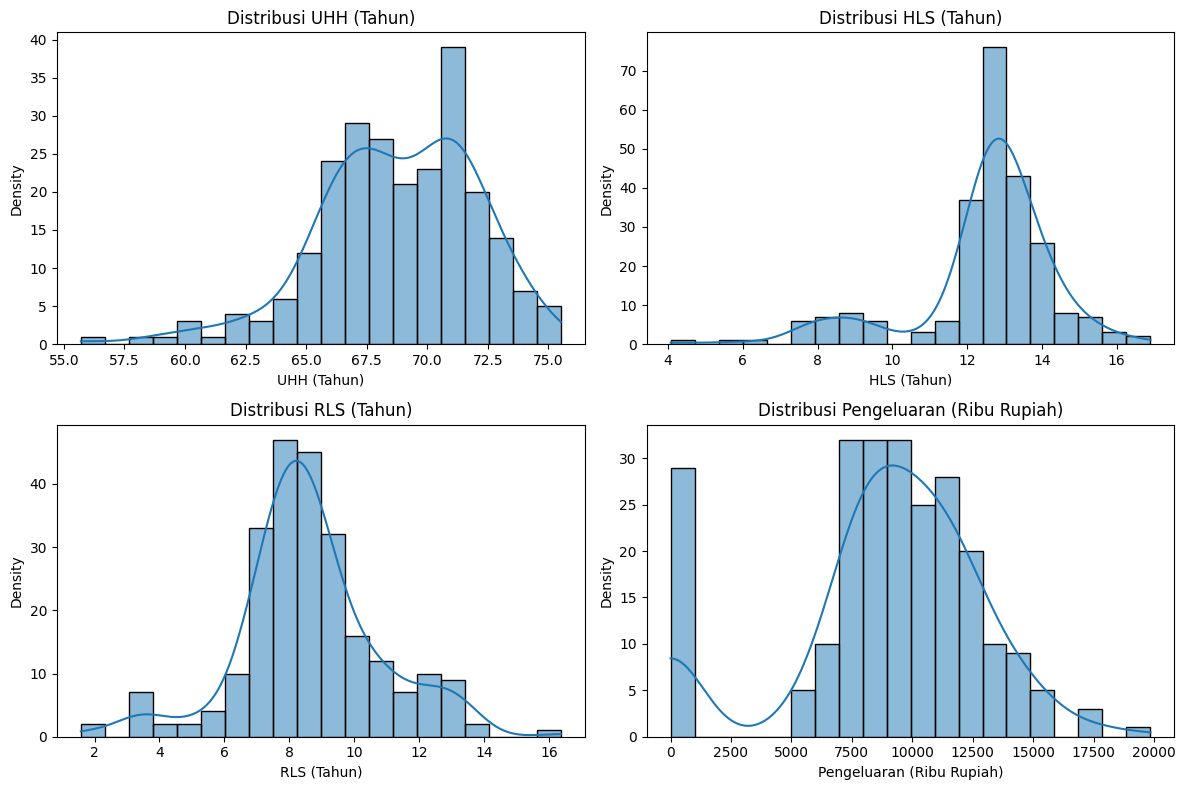

In [ ]:
# Membuat plot untuk setiap kolom
plt.figure(figsize=(12, 8))

for i, kolom in enumerate(df_atribut, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[kolom], bins=20, kde=True)
    plt.title(f'Distribusi {kolom}')
    plt.xlabel(kolom)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

**Mendeteksi Outlier dengan melakukan visualisasi apakah terdapat nilai outlier pada setiap variabel. Dapat dikatakan terdapat outlier, jika melebihi quartil atas dan quartil bawah**

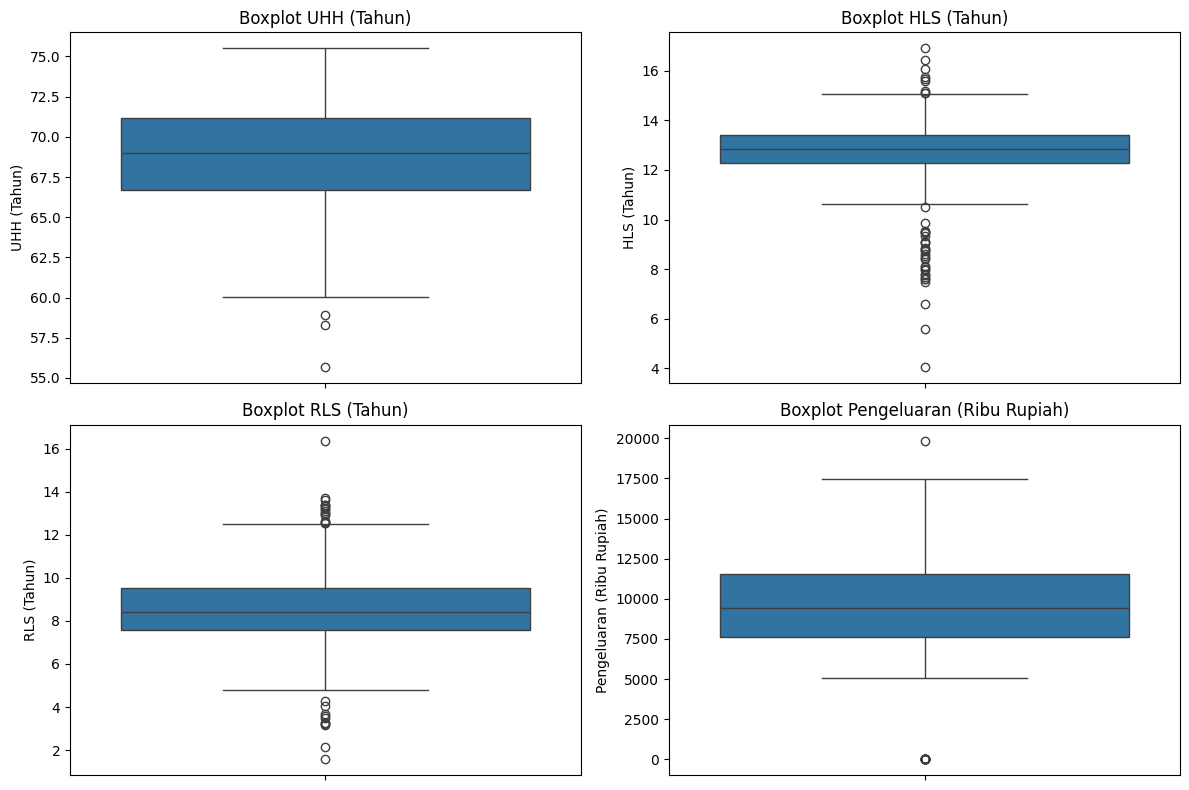

In [ ]:
# Visualisasi distribusi data dengan boxplot sebelum menangani outlier
plt.figure(figsize=(12, 8))

for i, kolom in enumerate(df_atribut, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[kolom])
    plt.title(f'Boxplot {kolom}')
    plt.ylabel(kolom)

plt.tight_layout()
plt.show()

**Mengatasi Nilai Outlier pada Data dengan Normalisasi**

Dapat dilihat dari hasil visualisasi menggunakan boxplot sebelumnya, bahwa terdapat outlier pada setiap variabel sehingga perlu dilakukan normalisasi data Min Max

In [ ]:
import numpy as np
import pandas as pd

# Membaca data
data = df_atribut
# Normalisasi Min-Max
datanorm = (data - data.min()) / (data.max() - data.min())

print("\nData Setelah Normalisasi Min-Max:")
datanorm


Data Setelah Normalisasi Min-Max:


,UHH (Tahun),HLS (Tahun),RLS (Tahun),Pengeluaran (Ribu Rupiah)
0,0.586068,0.789556,0.504736,0.000314
1,0.230187,0.682775,0.281461,0.000180
2,0.593135,0.805144,0.587957,0.000304
3,0.641595,0.652377,0.580514,0.000244
4,0.691065,0.680436,0.548714,0.000176
...,...,...,...,...
236,0.220091,0.688231,0.482409,0.483065
237,0.367491,0.658613,0.486468,0.353012
238,0.554770,0.682775,0.438430,0.388586
239,0.772337,0.933749,0.719215,0.725635


**DBSCAN Clustering**

Dengan mengklasterkan menggunakan DBSCAN bertujuan untuk menemukan nilai epsilon terbaik untuk DBSCAN dan melakukan klusterisasi data menggunakan nilai epsilon tersebut, kemudian menampilkan informasi mengenai hasil klasterisasi seperti jumlah kluster yang terbentuk

In [ ]:
x = df[['UHH (Tahun)', 'HLS (Tahun)', 'RLS (Tahun)', 'Pengeluaran (Ribu Rupiah)']]

Dapat dilihat dari hasil yang ditampilkan bahwa terbentuk 4 klaster dengan nilai epsilon terbaik sebesar = 1.2

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(df_atribut)

# Find the best epsilon
eps_grid = np.linspace(0.3, 1.2, num=10)
silhouette_scores = []
eps_best = eps_grid[0]
silhouette_score_max = -1
model_best = None
labels_best = None

for eps in eps_grid:
    # Train DBSCAN clustering model
    model = DBSCAN(eps=eps, min_samples=5).fit(x)
    # Extract labels
    labels = model.labels_

    # Number of clusters in the labels, ignoring noise if present
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if num_clusters > 1:
        # Extract performance metric
        silhouette_score = round(metrics.silhouette_score(x, labels), 4)
        silhouette_scores.append(silhouette_score)
        print("Epsilon:", eps, " --> silhouette score:", silhouette_score)

        if silhouette_score > silhouette_score_max:
            silhouette_score_max = silhouette_score
            eps_best = eps
            model_best = model
            labels_best = labels
    else:
        silhouette_scores.append(-1)
        print("Epsilon:", eps, " --> insufficient clusters for silhouette score")

# Best params
print("\nBest epsilon =", eps_best)

# Associated model and labels for best epsilon
model = model_best
labels = labels_best

if labels_best is not None:
    # Check for unassigned datapoints in the labels
    offset = 0
    if -1 in labels:
        offset = 1

    # Number of clusters in the data
    num_clusters = len(set(labels)) - offset
    print("\nEstimated number of clusters =", num_clusters)
else:
    print("No valid clustering was found.")


Epsilon: 0.3  --> silhouette score: -0.3874
Epsilon: 0.39999999999999997  --> silhouette score: -0.234
Epsilon: 0.5  --> silhouette score: 0.0294
Epsilon: 0.6  --> silhouette score: 0.1406
Epsilon: 0.7  --> silhouette score: 0.3155
Epsilon: 0.7999999999999999  --> silhouette score: 0.3827
Epsilon: 0.8999999999999999  --> silhouette score: 0.3999
Epsilon: 1.0  --> silhouette score: 0.4188
Epsilon: 1.0999999999999999  --> silhouette score: 0.4289
Epsilon: 1.2  --> silhouette score: 0.4347

Best epsilon = 1.2

Estimated number of clusters = 4


In [ ]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=4.7, min_samples=5)
labels = dbscan.fit_predict(x)
np.unique(labels)

array([0])

**Setelah ditemukan nilai epsilon terbaik yang didapat, selanjutnya yaitu melatih model pada data dan menghasilkan label klaster untuk setiap titik data**

In [ ]:
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=1.2,min_samples=5,metric='euclidean')

In [ ]:
model=db.fit(x)

In [ ]:
label=model.labels_

In [ ]:
label

array([ 0, -1,  0,  0,  0,  0,  1,  1,  0, -1,  0, -1,  1,  1,  1,  0,  0,
        0,  0, -1, -1,  1,  1,  1,  1,  1,  1,  1,  0,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3, -1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

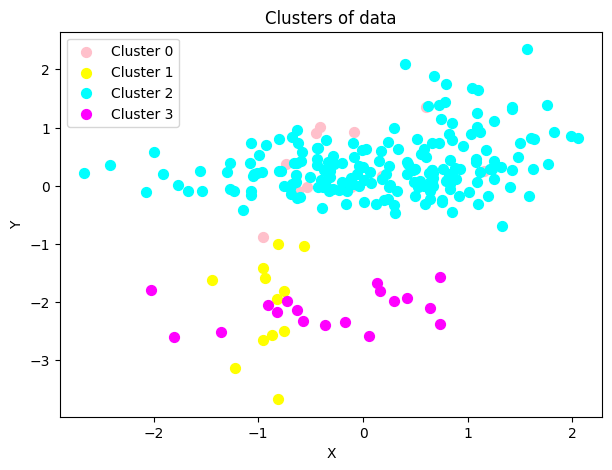

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Misalkan x adalah dataset yang sudah ada
# dan db adalah objek DBSCAN yang sudah diinisialisasi

# Melakukan clustering
y_means = db.fit_predict(x)

# Menentukan warna untuk setiap cluster
colors = ['pink', 'yellow', 'cyan', 'magenta']
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

# Membuat plot
plt.figure(figsize=(7, 5))
for i, color, label in zip(range(4), colors, labels):
    plt.scatter(x[y_means == i, 0], x[y_means == i, 1], s=50, c=color, label=label)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Clusters of data')
plt.legend()
plt.show()


Hasil visualisasi yang ditampilkan dari DBSCAN Clustering ini dapat dilihat bahwa terbagi menjadi 4 cluster dimana cluster 0 berwarna pink, cluster 1 berwarna kuning, cluster 2 berwarna hijau tosca, dan cluster 4 berwarna pink tua

**Hasil Klaster pada Setiap Kota/Kab**

In [ ]:
# Tambahkan informasi cluster ke dalam DataFrame
df['Cluster'] = label

# Cetak DataFrame untuk menampilkan kecamatan dan clusternya
cluster = df[['Kota/Kabupaten', 'Cluster']]
cluster

,Kota/Kabupaten,Cluster
0,Papua-Merauke,Cluster 3
1,Jayawijaya,Cluster 3
2,Jayapura,Cluster 3
3,Nabire,Cluster 3
4,Kepulauan Yapen,Cluster 3
...,...,...
236,Seram Bagian Timur,Cluster 3
237,Maluku Barat Daya,Cluster 3
238,Buru Selatan,Cluster 3
239,Ambon,Cluster 3


**Menghitung jumlah dari setiap cluster yang terbentuk (Kecuali cluster -1 atau noise)**

In [ ]:
# Menghitung jumlah tiap cluster (tidak termasuk cluster -1)
cluster_counts = df[df['Cluster'] != -1]['Cluster'].value_counts()
cluster_counts

Cluster
Cluster 3    241
Name: count, dtype: int64

In [ ]:
# Metrik evaluasi internal
sil_score = silhouette_score(x, labels_best)
db_score = davies_bouldin_score(x, labels_best)
ch_score = calinski_harabasz_score(x, labels_best)

print("Silhouette Score:", sil_score)
print("Davies-Bouldin Index:", db_score)
print("Calinski-Harabasz Index:", ch_score)

# Jika Anda memiliki label ground truth
# Misalkan Anda memiliki kolom 'TrueLabels' dalam df dengan label sebenarnya
if 'TrueLabels' in df.columns:
    true_labels = df['TrueLabels']
    ari = adjusted_rand_score(true_labels, labels_best)
    nmi = normalized_mutual_info_score(true_labels, labels_best)

    print("Adjusted Rand Index (ARI):", ari)
    print("Normalized Mutual Information (NMI):", nmi)

Silhouette Score: 0.43474167798969043
Davies-Bouldin Index: 1.2013164891876393
Calinski-Harabasz Index: 65.580150012472


Dengan nilai epsilon terbaik yaitu sebesar 1.2, DBSCAN menghasilkan clustering dengan 4 cluster yang berbeda dan metrik evaluasi interval menunjukkan clustering yang cukup baik dengan silhouette score sesbesar 0.4347, davies-bouldin index sebesar 1.2013, dan calinski-harabasz index sebesar 65.5801. Namun jika dibandingkan dengan hasil silhouette score dari metode k-means jauh lebih baik k-means

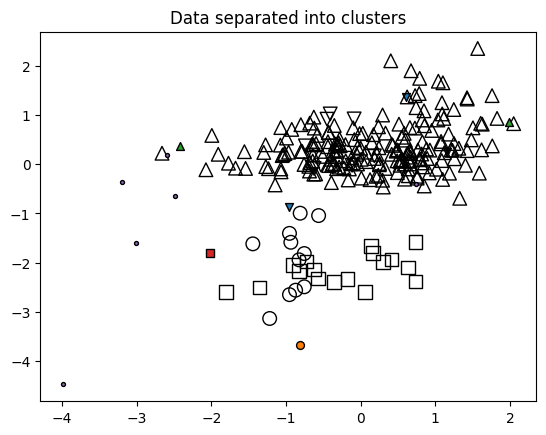

In [ ]:
# Extracts the core samples from the trained model
mask_core = np.zeros(labels.shape, dtype=bool)
mask_core[model.core_sample_indices_] = True

# Plot resultant cluster
plt.figure()
labels_uniq = set(labels)
markers = cycle('vo^s<>')

for cur_label, marker in zip(labels_uniq, markers):
    # Use black dots for unassigned datapoints
    if cur_label == -1:
        marker = '.'
    # Create mask for the current label
    cur_mask = (labels == cur_label)
    cur_data = x[cur_mask & mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker, edgecolors='black', s=96, facecolors='none')
    cur_data = x[cur_mask & ~mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker, edgecolors='black', s=32)

plt.title('Data separated into clusters')
plt.show()

**Visualisasi Hasil Clustering dengan Berbagai Bentuk Penanda yang Berbeda**

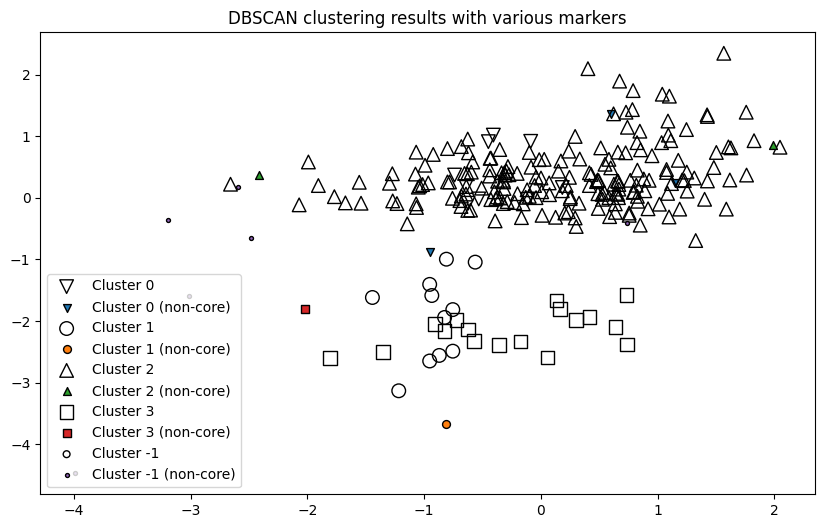

In [ ]:
# Visualisasi hasil klasterisasi dengan berbagai bentuk penanda
unique_labels = set(labels_best)
markers = cycle('vo^s<>')

plt.figure(figsize=(10, 6))

for cur_label, marker in zip(unique_labels, markers):
    if cur_label == -1:
        # Use black dot for noise
        col = 'k'
        marker = '.'
    else:
        col = plt.cm.nipy_spectral(float(cur_label) / num_clusters)

    class_member_mask = (labels_best == cur_label)
    xy_core = x[class_member_mask & np.isin(np.arange(len(labels_best)), model_best.core_sample_indices_)]
    xy_non_core = x[class_member_mask & ~np.isin(np.arange(len(labels_best)), model_best.core_sample_indices_)]

    plt.scatter(xy_core[:, 0], xy_core[:, 1], marker=marker, edgecolors='black', s=96, facecolors='none', label=f'Cluster {cur_label}')
    plt.scatter(xy_non_core[:, 0], xy_non_core[:, 1], marker=marker, edgecolors='black', s=32, label=f'Cluster {cur_label} (non-core)')

plt.title('DBSCAN clustering results with various markers')
plt.legend()
plt.show()

Dari hasil plot visualisasi yang ditampilkan terdiri dari 4 penanda bentuk yang berbeda, bentuk-bentuk tersebut mewakilkan dari 4 cluster yang berbeda yaitu cluster 0 dengan bentuk segitiga terbalik, cluster 1 bentuk lingkaran, cluster 2 bentuk segitiga sama sisi, dan cluster 3 bentuk persegi